# Wrapper feature engineering with forward selection

In [12]:
#Import models 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import explained_variance_score

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import csv
import numpy as np

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [13]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

In [14]:
#Imported data are split into x_test, y_test and y_train: 
for i in range(0,X.shape[0],10):  
        x_test_forcv = X[i:i+10]
        y_test_forcv = y[i:i+10]
        x_train_forcv = np.concatenate((X[:i],X[i+10:]),axis=0)
        y_train_forcv = np.concatenate((y[:i],y[i+10:]),axis=0)
        #Cverting numpy to pandasdataframes
        X_test = pd.DataFrame(x_test_forcv)
        y_test = pd.DataFrame(y_test_forcv)
        y_train = pd.DataFrame(y_train_forcv)
        
print(X_train.shape)
X_test
y_train
y_test

(170, 432)


,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


# Forward selection method tested with SVM model

Forward selection method was used to reduced the number of features. The reduced number feature set is tested with a SVM model to find the accuracy, sensitivity and specificity. These values are used to compare the different feature engineering methods. 

Leave one out cross validation was used to find the average value of the accuracy, sensitivity and specificity. 

In [ ]:
# We used the mlxtend library for forward selection.
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Performance metric saved here
average_accuracy_score = 0
score = []
svm_accuracy_score = []
svm_sensitivity = []
svm_specificity = []

#Function below runs the SVM model with the given new training and test. This function is called in a for loop for CV. 
#In this function, forward feature selection occurs and the reduced features are tested in a SVM model. 
#This function saves the average accuracy score, sensivitiy and specificity as a global variable. 
def run_svm(X_tr,X_te,y_tr,y_te,i):
        #Global variables
        global average_accuracy_score,score, svm_accuracy_score, svm_sensitivity, svm_specificity, start_time
        start_time = datetime.now()
        
        #Hyper parameter for model 
        param_grid = {'C':[1],'kernel':['linear']}
        #CV to train model with the best hyper parameter:
        grid = GridSearchCV(SVC(),param_grid)
        #Fit model
        grid.fit(X_tr,y_tr.values.ravel())
        print('imhere at i = :') # just to check
        
        #mlxtend library function. This allow us to apply forward feature selection engineering 
        ffs = SFS(grid,            #model
           k_features=175,         #Number of features
           forward=True,           #Forward
           floating=False, 
           verbose=2,
           scoring='accuracy',
           n_jobs=-1)
        
        #Fit to reduce features with forward selection
        ffs = ffs.fit(X_tr, y_tr)
        X_train_reducedfeat = ffs.transform(X_tr)
        X_test_reducedfeat = ffs.transform(X_te)

        #SVM is tested to find the performance metrics with the reduced feature test from the 
        #forward selection method
        param = {'C':[0.1,1,100,1000]} #add more params
        grid_svc= GridSearchCV(SVC(),param)
        grid_svc.fit(X_train_reducedfeat, y_tr)
        y_pred = grid_svc.predict(X_test_reducedfeat)
        
        #Calculate performance metric and confusion matrix
        accuracyscore = accuracy_score(y_te, y_pred)
        score.append(accuracyscore)
        average_accuracy_score = average_accuracy_score + (accuracy_score(y_te,y_pred))
        conf_matrix=confusion_matrix(y_te,y_pred,labels=[0,1])
        sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
        specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        
        #Plot confusion matrix
        print("Confusion Matrix:")
        print(conf_matrix)
        print("sensitivity:", sensitivity)
        print("Specificity:", specificity)
        sns.heatmap(conf_matrix,cmap="GnBu",annot=True,
        #cbar_kws={"orientation":"vertical","label":"color bar"},
        xticklabels=[0,1],yticklabels=[0,1])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

        #Save accuracy, sensitivity and specficity as an array
        svm_accuracy_score.append(accuracy_score(y_te,y_pred))
        svm_sensitivity.append(sensitivity)
        svm_specificity.append(specificity)
        
accuracy_score_list = []


#For loop is used to allow for cross validation (leave one out cross validation)
for i in range(0,X.shape[0],10):
    #Loop finds the new test and training data to pass through model for CV. 
        x_test_forcv = X[i:i+10]
        y_test_forcv = y[i:i+10]
        x_train_forcv = np.concatenate((X[:i],X[i+10:]),axis=0)
        y_train_forcv = np.concatenate((y[:i],y[i+10:]),axis=0)
        
        #Converting numpy to pandasdataframes
        X_train = pd.DataFrame(x_train_forcv)
        X_test = pd.DataFrame(x_test_forcv)
        y_test = pd.DataFrame(y_test_forcv)
        y_train = pd.DataFrame(y_train_forcv)
        
        #Pass training data and test data to model and for forward selection feature engineering
        run_svm(X_train,X_test,y_train,y_test,i)
        end_time = datetime.now()
        print('no. of iteration',i+10,'Duration: {}'.format(end_time - start_time))
        print('Average svm score for the model for considering',average_accuracy_score/18)
        accuracy_score_list.append(average_accuracy_score/18)
        average_accuracy_score = 0


print('mean wrt loocv:',accuracy_score_list)


In [ ]:
#The code below prints the average accuracy, standard deviation of the accuracy, mean sensivity and mean specificity: 
#This is for the SVM model:

print("Accuracy score Mean:")
print(np.mean(svm_accuracy_score))
print("\n Accuracy score Sd:")
print(np.std(svm_accuracy_score))
print("\n Sensivitity score mean:")
print(np.nanmean(svm_sensitivity))
print("\n Specificity score mean:")
print(np.nanmean(svm_specificity))

# Forward selection method tested with Logistic regression model

The same code is copied and modified to test a logisic regression model. A logisic regression model is used for forward selection method

Forward selection method was used to reduced the number of features. The reduced number feature set is tested with a logistic regression model to find the accuracy, sensitivity and specificity. These values are used to compare the different feature engineering methods. 

Leave one out cross validation was used to find the average value of the accuracy, sensitivity and specificity. 

0 (10, 432) (10,) (170, 432) (170,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:    8.9s finished

[2022-12-01 23:28:20] Features: 1/175 -- score: 0.7[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    5.1s finished

[2022-12-01 23:28:25] Features: 2/175 -- score: 0.7823529411764706[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 407 out of 430 | elapsed:    3.9s remaining:  

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    4.5s finished

[2022-12-01 23:30:03] Features: 23/175 -- score: 0.8352941176470587[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 386 out of 409 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 409 out of 409 | elapsed:    4.6s finished

[2022-12-01 23:30:08] Features: 24/175 -- score: 0.8352941176470587[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 408 out of 408 | elapsed:    4.6s finished

[2022-12-01 23:30:13] Features: 25/175 -- s

[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 366 out of 389 | elapsed:    5.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    5.3s finished

[2022-12-01 23:31:54] Features: 44/175 -- score: 0.8529411764705882[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 388 out of 388 | elapsed:    4.7s finished

[2022-12-01 23:31:58] Features: 45/175 -- score: 0.8529411764705882[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 364 out of 387 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 387 out of 387 | elapsed:    4.7s finished

[2022-12-01 23:32:03] Fe

[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:    5.7s finished

[2022-12-01 23:33:58] Features: 65/175 -- score: 0.8941176470588236[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 344 out of 367 | elapsed:    5.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 367 out of 367 | elapsed:    5.4s finished

[2022-12-01 23:34:03] Features: 66/175 -- score: 0.8941176470588236[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 366 out of 366 | elapsed:    6.8s finished

[2022-12-01 23:34:10] Features: 67/175 -- score: 0.8941176470588236[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: 

[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 346 out of 346 | elapsed:    4.9s finished

[2022-12-01 23:35:56] Features: 87/175 -- score: 0.9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 322 out of 345 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    4.8s finished

[2022-12-01 23:36:01] Features: 88/175 -- score: 0.9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    4.9s finished

[2022-12-01 23:36:06] Features: 89/175 -- score: 0.9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Paral

[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 301 out of 324 | elapsed:    4.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    4.8s finished

[2022-12-01 23:37:47] Features: 109/175 -- score: 0.9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 300 out of 323 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 323 out of 323 | elapsed:    4.6s finished

[2022-12-01 23:37:52] Features: 110/175 -- score: 0.9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 299 out of 322 | elapsed:    4.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 322 out of 322 

[2022-12-01 23:39:37] Features: 131/175 -- score: 0.9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 278 out of 301 | elapsed:    5.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 301 out of 301 | elapsed:    5.2s finished

[2022-12-01 23:39:43] Features: 132/175 -- score: 0.9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.6s finished

[2022-12-01 23:39:49] Features: 133/175 -- score: 0.9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.7s
[Parallel(n_j

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 278 out of 278 | elapsed:    5.6s finished

[2022-12-01 23:41:42] Features: 155/175 -- score: 0.9117647058823529[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 277 out of 277 | elapsed:    5.7s finished

[2022-12-01 23:41:48] Features: 156/175 -- score: 0.9117647058823529[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 253 out of 276 | elapsed:    5.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    5.3s finished

[2022-12-01 23:41:53] Features: 157/175 -- score: 0.9117647058823529[Parallel(n_jobs=-1)]: Using backen

Confusion Matrix:
[[7 3]
 [0 0]]
sensitivity: nan
Specificity: 0.7


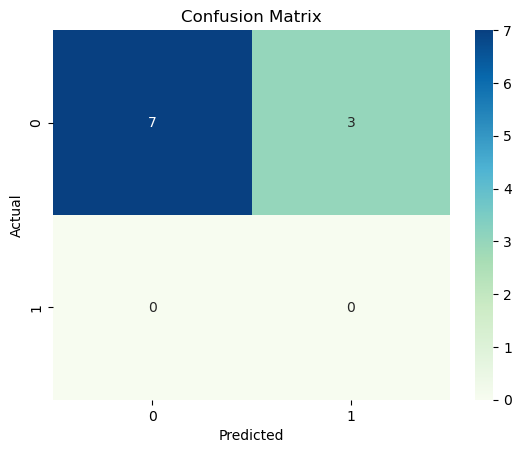

no. of iteration 10 Duration: 0:15:16.077601
Average svm score for the model for considering 0.03888888888888889
10 (10, 432) (10,) (170, 432) (170,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:    4.1s finished

[2022-12-01 23:43:32] Features: 1/175 -- score: 0.7[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 408 out of 431 | elapsed:    3.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    4.0s finished

[2022-12-01 23:43:36] Features: 2/175 -- score: 0.7411764705882353[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 430 out of 430 | elapsed:  

[Parallel(n_jobs=-1)]: Done 388 out of 411 | elapsed:    5.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 411 out of 411 | elapsed:    5.9s finished

[2022-12-01 23:45:10] Features: 22/175 -- score: 0.8235294117647058[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    5.0s finished

[2022-12-01 23:45:15] Features: 23/175 -- score: 0.8235294117647058[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 386 out of 409 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 409 out of 409 | elapsed:    5.0s finished

[2022-12-01 23:45:20] Features: 24/175 -- score: 0.8235294117647058[Parallel(n_jobs=-1

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 366 out of 389 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    5.0s finished

[2022-12-01 23:47:03] Features: 44/175 -- score: 0.8470588235294118[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 388 out of 388 | elapsed:    5.4s finished

[2022-12-01 23:47:08] Features: 45/175 -- score: 0.8470588235294118[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 364 out of 387 | elapsed:    5.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 387 ou

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 344 out of 367 | elapsed:    5.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 367 out of 367 | elapsed:    5.4s finished

[2022-12-01 23:49:06] Features: 66/175 -- score: 0.8470588235294118[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 366 out of 366 | elapsed:    5.9s finished

[2022-12-01 23:49:12] Features: 67/175 -- score: 0.8470588235294118[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 342 out of 365 | elapsed:    5.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 365 ou

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 322 out of 345 | elapsed:    5.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    5.6s finished

[2022-12-01 23:51:08] Features: 88/175 -- score: 0.8470588235294118[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    5.7s finished

[2022-12-01 23:51:14] Features: 89/175 -- score: 0.8470588235294118[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 320 out of 343 | elapsed:    5.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 343 ou

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 322 out of 322 | elapsed:    5.7s finished

[2022-12-01 23:53:39] Features: 111/175 -- score: 0.8647058823529411[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 298 out of 321 | elapsed:    4.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 321 out of 321 | elapsed:    5.1s finished

[2022-12-01 23:53:45] Features: 112/175 -- score: 0.8764705882352942[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    5.2s finished

[2022-12-01 23:53:50] Features: 113/175 -

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.4s finished

[2022-12-01 23:55:41] Features: 133/175 -- score: 0.8823529411764707[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 276 out of 299 | elapsed:    5.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 299 out of 299 | elapsed:    5.4s finished

[2022-12-01 23:55:46] Features: 134/175 -- score: 0.8823529411764707[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 298 out of 298 | elapsed:    5.5s finished

[2022-12-01 23:55:52] Features: 135/175 -

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:    5.7s finished

[2022-12-01 23:58:02] Features: 157/175 -- score: 0.8941176470588236[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:    5.6s finished

[2022-12-01 23:58:08] Features: 158/175 -- score: 0.8941176470588236[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    5.4s finished

[2022-12-01 23:58:13] Features: 159/175 -- score: 0.8941176470588236[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 250 out of 

Confusion Matrix:
[[7 3]
 [0 0]]
sensitivity: nan
Specificity: 0.7


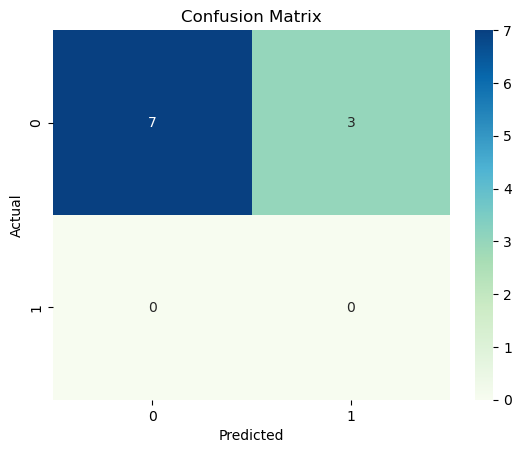

no. of iteration 20 Duration: 0:16:15.733444
Average svm score for the model for considering 0.03888888888888889
20 (10, 432) (10,) (170, 432) (170,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:    5.1s finished

[2022-12-01 23:59:48] Features: 1/175 -- score: 0.7058823529411764[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 408 out of 431 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    5.1s finished

[2022-12-01 23:59:53] Features: 2/175 -- score: 0.7823529411764706[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 430 out of 4

[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 388 out of 411 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 411 out of 411 | elapsed:    5.0s finished

[2022-12-02 00:01:29] Features: 22/175 -- score: 0.8529411764705882[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    4.6s finished

[2022-12-02 00:01:34] Features: 23/175 -- score: 0.8529411764705882[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 386 out of 409 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 409 out of 409 | elapsed:    4.9s finished

[2022-12-02 00:01:39] Fe

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 366 out of 389 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 389 out of 389 | elapsed:    4.4s finished

[2022-12-02 00:03:19] Features: 44/175 -- score: 0.8529411764705882[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 388 out of 388 | elapsed:    4.4s finished

[2022-12-02 00:03:23] Features: 45/175 -- score: 0.8529411764705882[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 364 out of 387 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 387 ou

[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:    4.6s finished

[2022-12-02 00:04:55] Features: 65/175 -- score: 0.8647058823529413[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 344 out of 367 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 367 out of 367 | elapsed:    4.5s finished

[2022-12-02 00:05:00] Features: 66/175 -- score: 0.8647058823529413[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 366 out of 366 | elapsed:    4.4s finished

[2022-12-02 00:05:04] Features: 67/175 -- score: 0.8647058823529413[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: 

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 346 out of 346 | elapsed:    4.6s finished

[2022-12-02 00:06:37] Features: 87/175 -- score: 0.8705882352941178[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 322 out of 345 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed:    4.6s finished

[2022-12-02 00:06:41] Features: 88/175 -- score: 0.8705882352941178[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 344 out of 344 | elapsed:    4.7s finished

[2022-12-02 00:06:46] Features: 89/175 -- s

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    4.6s finished

[2022-12-02 00:08:20] Features: 109/175 -- score: 0.8705882352941178[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 300 out of 323 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 323 out of 323 | elapsed:    4.7s finished

[2022-12-02 00:08:25] Features: 110/175 -- score: 0.8705882352941178[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 322 out of 322 | elapsed:    4.4s finished

[2022-12-02 00:08:29] Features: 111/175 -

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 302 out of 302 | elapsed:    4.7s finished

[2022-12-02 00:10:08] Features: 131/175 -- score: 0.8823529411764707[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 301 out of 301 | elapsed:    4.8s finished

[2022-12-02 00:10:13] Features: 132/175 -- score: 0.8823529411764707[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.7s finished

[2022-12-02 00:10:18] Features: 133/175 -- score: 0.8823529411764707[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

AttributeError: SequentialFeatureSelector has not been fitted, yet.

In [16]:
# We used the mlxtend library for forward selection.
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Performance metric saved here
lr_accuracy_score = []
lr_sensitivity = []
lr_specificity = []
average_accuracy_score = 0
score = []


#Function below runs the SVM model with the given new training and test. This function is called in a for loop for CV. 
#In this function, forward feature selection occurs and the reduced features are tested in a logistic regression model. 
#This function saves the average accuracy score, sensivitiy and specificity as a global variable. 

def run_lr(X_tr,X_te,y_tr,y_te):
        #Global variables
        global average_accuracy_score,score, lr_accuracy_score, lr_sensitivity, lr_specificity,start_time
        start_time = datetime.now()
        
        #Hyper parameter for model 
        param_grid_lr = [{'penalty' : ['l2'],#, 'elasticnet', 'none','l1',]
               'C' : [1],
               'solver' : ['liblinear'],
               }]
        
        #CV to train model with the best hyper parameter
        grid = GridSearchCV(LogisticRegression(),param_grid_lr)
        #Fit model
        grid.fit(X_tr,y_tr.values.ravel())
        #mlxtend library function. This allow us to apply forward feature selection engineering 
        #Logistic regression model used for forward selection
        ffs = SFS(grid, 
           k_features=175, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           n_jobs=-1)
        
        #Fit to reduce features with forward selection
        ffs = ffs.fit(X_tr, y_tr)
        X_train_reducedfeat = ffs.transform(X_tr)
        X_test_reducedfeat = ffs.transform(X_te)
        #LR is tested to find the performance metrics with the reduced feature test from the 
        #forward selection method        
        grid_LR= GridSearchCV(LogisticRegression(),param)
        grid_LR.fit(X_train_reducedfeat, y_tr)
        y_pred = grid_LR.predict(X_test_reducedfeat)
        
        #Calculate performance metric and confusion matrix
        accuracyscore = accuracy_score(y_te, y_pred)
        score.append(accuracyscore)
        average_accuracy_score = average_accuracy_score + (accuracy_score(y_te,y_pred))
        conf_matrix=confusion_matrix(y_te,y_pred,labels=[0,1])
        sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
        specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])

        #Plot confusion matrix
        print("Confusion Matrix:")
        print(conf_matrix)
        print("sensitivity:", sensitivity)
        print("Specificity:", specificity)
        sns.heatmap(conf_matrix,cmap="GnBu",annot=True,
        #cbar_kws={"orientation":"vertical","label":"color bar"},
        xticklabels=[0,1],yticklabels=[0,1])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

        #Save accuracy, sensitivity and specficity as an array
        lr_accuracy_score.append(accuracy_score(y_te,y_pred))
        lr_sensitivity.append(sensitivity)
        lr_specificity.append(specificity)      
 
accuracy_score_list = []

#For loop is used to allow for cross validation (leave one out cross validation)
for i in range(0,X.shape[0],10):  
        #Loop finds the new test and training data to pass through model for CV. 
        x_test_forcv = X[i:i+10]
        y_test_forcv = y[i:i+10]
        x_train_forcv = np.concatenate((X[:i],X[i+10:]),axis=0)
        y_train_forcv = np.concatenate((y[:i],y[i+10:]),axis=0)
        #Converting numpy to pandasdataframes
        X_train = pd.DataFrame(x_train_forcv)
        X_test = pd.DataFrame(x_test_forcv)
        y_test = pd.DataFrame(y_test_forcv)
        y_train = pd.DataFrame(y_train_forcv)
     
        #Pass training data and test data to model and for forward selection feature engineering
        run_lr(X_train,X_test,y_train,y_test)

        end_time = datetime.now()
        print('no. of iteration',i+10,'Duration: {}'.format(end_time - start_time))
        print('Average svm score for the model for considering',average_accuracy_score/18)
        accuracy_score_list.append(average_accuracy_score/18)
        average_accuracy_score = 0

print('mean wrt loocv:',accuracy_score_list)

#plot for last case only
#mi_score.plot.bar(figsize = (16,7))

In [ ]:
#The code below prints the average accuracy, standard deviation of the accuracy, mean sensivity and mean specificity: 
#This is for the logisitc model:
print("Accuracy score Mean:")
print(np.mean(lr_accuracy_score))
print("\n Accuracy score Sd:")
print(np.std(lr_accuracy_score))
print("\n Sensivitity score mean:")
print(np.nanmean(lr_sensitivity))
print("\n Specificity score mean:")
print(np.nanmean(lr_specificity))